# Start you dataset visualization here  
### modify the analysis_file to the string where the dataframe file (.csv) produced by SymDesign.py analysis lives and the filter_file variable to the provided symdesign/data/filter_and_sort_df.csv

In [5]:
!pwd

/home/kylemeador/symdesign/jupyter_notebooks


In [1]:
trajectory_analysis_file = '/home/kylemeador/designs/T33/3pac_3q98/3pac_3q98-DEGEN_1_1-ROT_33_39-tx_288_Trajectories_CORRECTED.csv'  # YOUR ANALYSIS FILE HERE
residue_analysis_file = '/home/kylemeador/designs/T33/3pac_3q98/3pac_3q98-DEGEN_1_1-ROT_33_39-tx_288_Residues_fixed.csv'  # YOUR ANALYSIS FILE HERE

Import the required packages

In [2]:
import os
import sys
import math
import operator
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


symdesign_main = os.path.dirname(os.environ.get('SymDesign'))
sys.path.append(symdesign_main)

from DesignMetrics import master_metrics

Magic methods ensure any changes to imported files stay current in the notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
mean = 'mean'
std = 'std'
idx_slice = pd.IndexSlice

In [5]:
def columns_to_new_column(df, column_dict, mode='add'):
    """Find new column values by taking an operation of one column on another

    Args:
        df (pandas.DataFrame): Dataframe where the columns are located
        column_dict (dict): A dictionary with keys as new column names, values as tuple of columns.
            Where value[0] mode(operation) value[1] = key
    Keyword Args:
        mode='add' (str) = What operator to use?
            Viable options are included in module operator, but could be 'sub', 'mul', 'truediv', etc.
    Returns:
        df (pandas.DataFrame): Dataframe with new column values
    """
    for column in column_dict:
        try:
            df[column] = operator.attrgetter(mode)(operator)(df[column_dict[column][0]], df[column_dict[column][1]])
        except KeyError:
            pass

    return df

In [6]:
# need {column: {'direction': 'max', 'val': 0.5, 'idx': []}, ...}
def df_filter_index_by_value(df, **kwargs):
    """Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
    on whether the column should be sorted max/min
    Args:
        df (pandas.DataFrame): DataFrame to filter indices on
    Keyword Args:
        kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
    """
    indices_l = []
    for _index in kwargs:
        if kwargs[_index]['direction'] == 'max':
            kwargs[_index]['idx'] = df[df[_index] >= kwargs[_index]['value']].index.to_list()
        if kwargs[_index]['direction'] == 'min':
            kwargs[_index]['idx'] = df[df[_index] <= kwargs[_index]['value']].index.to_list()
    
    return kwargs

In [7]:
def index_intersection(filtered_indices):
    """Take the intersection of provided indices in key, value pairs
    
    Args:
        filtered_indices (dict): {metric: indices, ...}
    Returns:
        (list): All indices in each provided metric
    """
    final_indices = set()
    # find all set union
    for metric in filtered_indices:
        final_indices = set(final_indices) | set(filtered_indices[metric])
        
    # find all set intersection
    for metric in filtered_indices:
        final_indices = set(final_indices) & set(filtered_indices[metric])
    return list(final_indices)

In [8]:
def return_df_feature_descriptors(df):
    """From a dataframe, return only the numeric features (columns) and their statistcial descriptions
    
    Returns:
        (pandas.DataFrame)
    """
    numerical_df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1)
    measures = {'mean': numerical_df.mean(), 
                'std': numerical_df.std(),
                'min': numerical_df.min(),
                'max': numerical_df.max()}
    descriptor_df = pd.DataFrame(measures)
    descriptor_df['range'] = descriptor_df['max'] - descriptor_df['min']
    return pd.concat([descriptor_df], keys=['descriptors'], axis=1)

Importing filter_key

In [9]:
traj_df = pd.read_csv(trajectory_analysis_file, index_col=0)
res_df = pd.read_csv(residue_analysis_file, index_col=0, header=[0,1])
residue_df = pd.read_csv(residue_analysis_file, header=[0,1])

## Visualize data descriptors (mean, standard deviation, min, max, range) for the dataframe

In [10]:
# traj_df.describe()
display(traj_df)

,buns_1_unbound,buns_2_unbound,buns_complex,contact_count,favor_residue_energy,interaction_energy_complex,interface_connectivity_1,interface_connectivity_2,interface_energy_complex,interface_separation,rmsd,rmsd_complex,rosetta_reference_energy,shape_complementarity,solvation_energy_complex,observed_design,observed_evolution,observed_fragment,number_hbonds,number_of_mutations,buns_unbound,interface_energy_bound,interface_energy_unbound,solvation_energy_bound,solvation_energy_unbound,interface_buried_hbonds,interface_energy,interface_bound_activation_energy,solvation_energy,interface_area_hydrophobic,interface_area_polar,interface_area_total,percent_interface_area_hydrophobic,percent_interface_area_polar,interface_energy_density,core,rim,support,interface_composition_similarity,protocol
0001,1.000000,5.000000,16.000000,4.616967,0.0,-56.595993,18.100719,14.351851,-205.200788,0.597640,0.153451,48.986075,228.673180,0.637027,226.231636,0.939000,0.939000,1.0,11.000000,49.000000,6.000000,-148.604795,10822.579844,207.931548,248.462515,10.000000,-11027.780632,-10971.184639,22.230879,1195.083689,439.476815,1634.560504,0.731135,0.268865,-6.746633,18.000000,13.000000,19.000000,0.864519,no_constraint
0002,1.000000,7.000000,14.000000,4.779951,0.0,-58.527146,18.325926,14.009434,-180.381071,0.513324,0.161317,48.993156,239.123500,0.714031,210.799235,0.909000,0.909000,1.0,4.000000,49.000000,8.000000,-121.853924,11002.878979,203.177713,232.240896,6.000000,-11183.260049,-11124.732903,21.441661,1331.119662,285.644658,1616.764320,0.823323,0.176677,-6.917063,17.000000,15.000000,17.000000,0.910748,design_profile
0003,1.000000,5.000000,13.000000,4.605000,0.0,-60.801303,17.739130,14.126214,-207.168740,0.608438,0.154730,48.987614,227.495690,0.621182,227.205629,0.879000,0.894000,1.0,5.000000,49.000000,6.000000,-146.367437,11407.088628,213.293470,239.703790,7.000000,-11614.257368,-11553.456066,12.498161,1342.502094,380.236461,1722.738556,0.779284,0.220716,-6.741741,22.000000,9.000000,20.000000,0.690989,no_constraint
0004,3.000000,5.000000,15.000000,4.543081,0.0,-56.875583,18.366907,14.134615,-194.754857,0.590711,0.163572,48.976653,231.051410,0.669760,215.882070,0.985000,0.970000,1.0,8.000000,48.000000,8.000000,-137.879274,11462.715451,197.953928,229.687451,7.000000,-11657.470308,-11600.594725,13.805381,1386.762527,429.558884,1816.321411,0.763501,0.236499,-6.418176,18.000000,14.000000,20.000000,0.865037,design_profile
0005,2.000000,5.000000,18.000000,4.397985,0.0,-66.562615,17.197081,14.226087,-178.718151,0.577825,0.157019,48.987498,238.239910,0.656507,204.631255,0.924000,0.924000,1.0,9.000000,49.000000,7.000000,-112.155537,10370.566610,192.961194,248.612099,11.000000,-10549.284761,-10482.722147,43.980844,1246.414536,428.032303,1674.446839,0.744374,0.255626,-6.300161,19.000000,13.000000,20.000000,0.829329,no_constraint
0006,2.000000,2.000000,12.000000,4.569620,0.0,-67.039991,16.459259,14.480769,-205.256522,0.562519,0.154999,48.991305,229.795210,0.638302,242.237811,0.894000,0.894000,1.0,10.000000,51.000000,4.000000,-138.216531,9503.362456,212.718390,261.919332,8.000000,-9708.618978,-9641.578987,19.681521,1345.793630,497.972688,1843.766318,0.729916,0.270084,-5.265645,21.000000,12.000000,20.000000,0.801576,no_constraint
0007,2.000000,3.000000,12.000000,4.506527,0.0,-51.957060,16.653847,14.245455,-195.190849,0.509032,0.163854,48.978466,226.940540,0.688870,230.609136,0.939000,0.939000,1.0,9.000000,51.000000,5.000000,-143.233789,11507.734773,205.291305,242.244541,7.000000,-11702.925621,-11650.968562,11.635406,1114.739939,445.290312,1560.030252,0.714563,0.285437,-7.501730,18.000000,12.000000,18.000000,0.850484,design_profile
0008,3.000000,4.000000,15.000000,4.692112,0.0,-62.124034,17.417267,14.205882,-173.619740,0.534943,0.162663,48.989945,239.164360,0.701159,201.501735,0.970000,0.970000,1.0,5.000000,51.000000,7.000000,-111.495706,11201.216933,195.659107,236.405205,8.000000,-11374.836673,-11312.712639,34.903471,1451.985233,291.403663,1743.388896,0.832852,0.167148

In [17]:
traj_df.sort_index()

,buns_1_unbound,buns_2_unbound,buns_complex,contact_count,favor_residue_energy,interaction_energy_complex,interface_connectivity_1,interface_connectivity_2,interface_energy_complex,interface_separation,rmsd,rmsd_complex,rosetta_reference_energy,shape_complementarity,solvation_energy_complex,observed_design,observed_evolution,observed_fragment,number_hbonds,number_of_mutations,buns_unbound,interface_energy_bound,interface_energy_unbound,solvation_energy_bound,solvation_energy_unbound,interface_buried_hbonds,interface_energy,interface_bound_activation_energy,solvation_energy,interface_area_hydrophobic,interface_area_polar,interface_area_total,percent_interface_area_hydrophobic,percent_interface_area_polar,interface_energy_density,core,rim,support,interface_composition_similarity,protocol
"(('design_profile', 'no_constraint'), 'similarity')",NaN,NaN,NaN,0.152000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.653000,NaN,NaN,NaN,NaN,0.808000,NaN,NaN,NaN,NaN,NaN,NaN,0.918000,0.997000,NaN,0.489000,NaN,NaN,0.346000,0.721000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001,1.000000,5.000000,16.000000,4.616967,0.0,-56.595993,18.100719,14.351851,-205.200788,0.597640,0.153451,48.986075,228.673180,0.637027,226.231636,0.939000,0.939000,1.0,11.000000,49.000000,6.000000,-148.604795,10822.579844,207.931548,248.462515,10.000000,-11027.780632,-10971.184639,22.230879,1195.083689,439.476815,1634.560504,0.731135,0.268865,-6.746633,18.000000,13.000000,19.000000,0.864519,no_constraint
0002,1.000000,7.000000,14.000000,4.779951,0.0,-58.527146,18.325926,14.009434,-180.381071,0.513324,0.161317,48.993156,239.123500,0.714031,210.799235,0.909000,0.909000,1.0,4.000000,49.000000,8.000000,-121.853924,11002.878979,203.177713,232.240896,6.000000,-11183.260049,-11124.732903,21.441661,1331.119662,285.644658,1616.764320,0.823323,0.176677,-6.917063,17.000000,15.000000,17.000000,0.910748,design_profile
0003,1.000000,5.000000,13.000000,4.605000,0.0,-60.801303,17.739130,14.126214,-207.168740,0.608438,0.154730,48.987614,227.495690,0.621182,227.205629,0.879000,0.894000,1.0,5.000000,49.000000,6.000000,-146.367437,11407.088628,213.293470,239.703790,7.000000,-11614.257368,-11553.456066,12.498161,1342.502094,380.236461,1722.738556,0.779284,0.220716,-6.741741,22.000000,9.000000,20.000000,0.690989,no_constraint
0004,3.000000,5.000000,15.000000,4.543081,0.0,-56.875583,18.366907,14.134615,-194.754857,0.590711,0.163572,48.976653,231.051410,0.669760,215.882070,0.985000,0.970000,1.0,8.000000,48.000000,8.000000,-137.879274,11462.715451,197.953928,229.687451,7.000000,-11657.470308,-11600.594725,13.805381,1386.762527,429.558884,1816.321411,0.763501,0.236499,-6.418176,18.000000,14.000000,20.000000,0.865037,design_profile
0005,2.000000,5.000000,18.000000,4.397985,0.0,-66.562615,17.197081,14.226087,-178.718151,0.577825,0.157019,48.987498,238.239910,0.656507,204.631255,0.924000,0.924000,1.0,9.000000,49.000000,7.000000,-112.155537,10370.566610,192.961194,248.612099,11.000000,-10549.284761,-10482.722147,43.980844,1246.414536,428.032303,1674.446839,0.744374,0.255626,-6.300161,19.000000,13.000000,20.000000,0.829329,no_constraint
0006,2.000000,2.000000,12.000000,4.569620,0.0,-67.039991,16.459259,14.480769,-205.256522,0.562519,0.154999,48.991305,229.795210,0.638302,242.237811,0.894000,0.894000,1.0,10.000000,51.000000,4.000000,-138.216531,9503.362456,212.718390,261.919332,8.000000,-9708.618978,-9641.578987,19.681521,1345.793630,497.972688,1843.766318,0.729916,0.270084,-5.265645,21.000000,12.000000,20.000000,0.801576,no_constraint
0007,2.000000,3.000000,12.000000,4.506527,0.0,-51.957060,16.653847,14.245455,-195.190849,0.509032,0.163854,48.978466,226.940540,0.688870,230.609136,0.939000,0.939000,1.0,9.000000,51.000000,5.000000,-143.233789,11507.734773,205.291305,242.244541,7.000000,-11702.925621,-11650.968562,11.635406,1114.739939,445.290312,1560.030252,0.714563,0.285437,-7.501730,18.000000,12.000000,18.000000,0.850484,design_profile
0008,3.000000,4.000000,15.000000,4.692112,0.0,-62.124034,17.417267,14.205882,-173.619740,0

In [15]:
pd.concat([traj_df.groupby('protocol').mean().T.unstack()], keys=['mean']).swaplevel(0, 1)

protocol                                              
design_profile  mean  buns_1_unbound                       2.500000
                      buns_2_unbound                       4.833333
                      buns_complex                        14.666667
                      contact_count                        4.622802
                      favor_residue_energy                 0.000000
                                                            ...    
no_constraint   mean  interface_energy_density            -5.928124
                      core                                20.625000
                      rim                                 11.125000
                      support                             20.000000
                      interface_composition_similarity     0.770211
Length: 78, dtype: float64

In [27]:
freqs = {'A': 0.10231387808429973, 'C': 0.010542902934855375, 'D': 0.03366718351360557, 
         'E': 0.04787849836756772, 'F': 0.048545872676132425, 'G': 0.03767655764600882, 
         'H': 0.023724831624564006, 'I': 0.08143385113741787, 'K': 0.03726226101304785, 
         'L': 0.11840529350902532, 'M': 0.025800118322000208, 'N': 0.03357590901830905, 
         'P': 0.04469311334836589, 'Q': 0.034981186261729504, 'R': 0.04253998368154658, 
         'S': 0.06166324780678608, 'T': 0.06474099610682482, 'V': 0.0976240503881432, 
         'W': 0.01132294474391948, 'Y': 0.035142163607323716}
order = 'KWCHQNMEDRYPSFTGIVAL'

<AxesSubplot:>

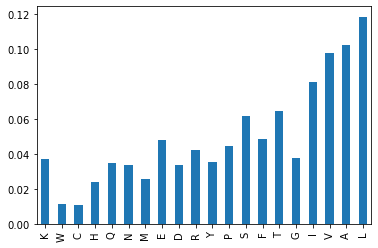

In [30]:
pd.Series({letter: freqs[letter] for letter in order}).plot(kind="bar")

In [16]:
traj_df.mean()

buns_1_unbound                           2.063036
buns_2_unbound                           4.177540
buns_complex                            13.039333
contact_count                            3.760830
favor_residue_energy                     0.000000
interaction_energy_complex             -51.683188
interface_connectivity_1                14.983444
interface_connectivity_2                12.077570
interface_energy_complex              -158.302610
interface_separation                     0.479022
rmsd                                     0.137040
rmsd_complex                            41.641010
rosetta_reference_energy               199.746420
shape_complementarity                    0.573966
solvation_energy_complex               187.145915
observed_design                          0.788271
observed_evolution                       0.787786
observed_fragment                        0.850000
number_hbonds                            6.453423
number_of_mutations                     42.531559


## I had to drop the 'protocol' level to handle this data, This was not trivial with multiindex as it is not dropped from the multiindex when it is dropped from the df

In [82]:
# res_df.columns.rename([{'Unnamed: 926_level_0': 'protocol'}, 'poop'], inplace=True)  #, level=0)
# res_df.columns.rename({('Unnamed: 926_level_0', 'protocol'): ('protocol', 'protocol')}, inplace=True)

# res_df_drop = res_df.drop([idx_slice[:, 'protocol']], axis=1)
# res_df.drop([('protocol', 'protocol')], axis=1, inplace=True)
res_df.columns = res_df.columns.set_levels(res_df.columns.levels[0].drop(['protocol']), level=0)


# res_df.loc[:, idx_slice[:, 'protocol']]  # 'Unnamed: 926_level_0'

In [67]:
res_df.columns.levels[0].tolist()

['1',
 '106',
 '109',
 '110',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '142',
 '144',
 '145',
 '147',
 '148',
 '149',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '386',
 '387',
 '388',
 '389',
 '390',
 '431',
 '432',
 '433',
 '434',
 '435',
 '436',
 '437',
 '439',
 '440',
 '441',
 '444',
 '446',
 '448',
 '449',
 '451',
 '452',
 '453',
 '454',
 '455',
 '456',
 '457',
 '458',
 '459',
 '460',
 '461',
 '462',
 '463',
 '464',
 '49',
 '74',
 '75',
 '76',
 '77',
 'protocol']

In [90]:
# residue_df = res_df.copy()
residue_df['protocol', 'protocol'] = traj_df['protocol']
residue_df

Unnamed: 0_level_0               1                      \
   Unnamed: 0_level_1 bsa_hydrophobic bsa_polar bsa_total   
0           wild_type             NaN       NaN     56.29   
1                   1            0.00      2.03      2.03   
2                   2            1.54     11.90     13.44   
3                   3            8.98     44.86     53.84   
4                   4           15.63     20.45     36.08   
5                   5           12.81     21.06     33.87   
6                   6           49.72     13.43     63.15   
7                   7            0.00     13.67     13.67   
8                   8            0.00      0.00      0.00   
9                   9            0.00     14.29     14.29   
10                 10           13.32     28.43     41.75   
11                 11           17.42     13.80     31.23   
12                 12           13.83     24.18     38.01   
13                 13            6.15     18.14     24.29   
14                 14            7.17     24.38     31.56   

                                                                           \
   coordinate_constraint core energy_delta hbond interior observed_design   
0                    NaN  NaN          NaN   NaN        0             NaN   
1           15947.572553  0.0    -4.044777   0.0        0             1.0   
2           15906.564613  0.0    -4.916352   0.0        0             1.0   
3           15913.380947  0.0    -3.703248   1.0        0             1.0   
4           15878.188658  0.0    -6.362362   1.0        0             1.0   
5           15888.843054  0.0    -5.641616   1.0        0             1.0   
6           15959.796872  0.0    -1.500015   0.0        0             0.0   
7           15943.452834  0.0    -1.764406   0.0        0             1.0   
8           15941.954464  0.0   -13.490256   0.0        0             1.0   
9           15941.153302  0.0    -3.879720   0.0        0             1.0   
10          15924.272638  0.0    -7.879220   1.0        0             1.0   
11          15921.858199  0.0    -4.519782   0.0        0             1.0   
12          15931.648476  0.0    -4.161340   1.0        0             1.0   
13          15938.493098  0.0    -0.224236   0.0        0             1.0   
14          15928.439622  0.0   -42.176685   0.0        0             1.0   

                                                                           \
   observed_evolution observed_fragment residue_favored  rim support type   
0                 NaN               NaN             NaN  NaN     NaN    S   
1                 1.0               1.0             0.0  1.0     0.0    D   
2                 1.0               1.0             0.0  1.0     0.0    E   
3                 1.0               1.0             0.0  1.0     0.0    D   
4                 1.0               1.0             0.0  1.0     0.0    Q   
5                 1.0               1.0             0.0  1.0     0.0    Q   
6                 0.0               1.0             0.0  1.0     0.0    I   
7                 1.0               1.0             0.0  1.0     0.0    D   
8                 1.0               1.0             0.0  0.0     0.0    D   
9                 1.0               1.0             0.0  1.0     0.0    D   
10                1.0               1.0             0.0  1.0     0.0    D   
11                1.0               1.0             0.0  1.0     0.0    E   
12                1.0               1.0             0.0  1.0     0.0    D   
13                1.0               1.0             0.0  1.0     0.0    D   
14                1.0               1.0             0.0  1.0     0.0    E   

               106                                                 \
   bsa_hydrophobic bsa_polar bsa_total coordinate_constraint core   
0              NaN       NaN      0.55                   NaN  NaN   
1             2.05      0.00      2.05           7550.768240  0.0   
2             0.00      0.00      0.00           7549.045914  0.0   


### Figuring out how to convert the residue_df to int so that it could be sorted properly

In [85]:
print(res_df.columns.levels[0].tolist())  # .astype(int))
res_df.columns = res_df.columns.set_levels(res_df.columns.levels[0].astype(int), level=0)
res_df.sort_index(level=0, axis=1, inplace=True, sort_remaining=False)  # , key=lambda x: int(x))

['1', '106', '109', '110', '112', '113', '114', '115', '116', '117', '118', '119', '142', '144', '145', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '386', '387', '388', '389', '390', '431', '432', '433', '434', '435', '436', '437', '439', '440', '441', '444', '446', '448', '449', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '49', '74', '75', '76', '77']


In [86]:
res_df.describe()

1                                                      \
      bsa_hydrophobic  bsa_polar  bsa_total coordinate_constraint  core   
count       14.000000  14.000000  15.000000             14.000000  14.0   
mean        10.469286  17.901429  30.233333          15926.115666   0.0   
std         12.980397  11.134423  19.120594             22.894063   0.0   
min          0.000000   0.000000   0.000000          15878.188658   0.0   
25%          0.385000  13.490000  13.980000          15915.500260   0.0   
50%          8.075000  16.215000  31.560000          15930.044049   0.0   
75%         13.702500  23.400000  39.880000          15941.754173   0.0   
max         49.720000  44.860000  63.150000          15959.796872   0.0   

                                                                           \
      energy_delta      hbond interior observed_design observed_evolution   
count    14.000000  14.000000     15.0       14.000000          14.000000   
mean     -7.447430   0.357143      0.0        0.928571           0.928571   
std      10.492510   0.497245      0.0        0.267261           0.267261   
min     -42.176685   0.000000      0.0        0.000000           0.000000   
25%      -6.182175   0.000000      0.0        1.000000           1.000000   
50%      -4.340561   0.000000      0.0        1.000000           1.000000   
75%      -3.747366   1.000000      0.0        1.000000           1.000000   
max      -0.224236   1.000000      0.0        1.000000           1.000000   

                                                                       49   \
      observed_fragment residue_favored        rim support bsa_hydrophobic   
count              14.0            14.0  14.000000    14.0       14.000000   
mean                1.0             0.0   0.928571     0.0       10.417857   
std                 0.0             0.0   0.267261     0.0        9.433928   
min                 1.0             0.0   0.000000     0.0        0.000000   
25%                 1.0             0.0   1.000000     0.0        1.020000   
50%                 1.0             0.0   1.000000     0.0        9.745000   
75%                 1.0             0.0   1.000000     0.0       19.737500   
max                 1.0             0.0   1.000000     0.0       20.760000   

                                                                           \
       bsa_polar  bsa_total coordinate_constraint       core energy_delta   
count  14.000000  15.000000             14.000000  14.000000    14.000000   
mean    4.257143  16.490667          15670.948368   0.428571   -12.206151   
std    10.215708  13.100643              4.034874   0.513553     6.657033   
min     0.000000   0.000000          15664.666127   0.000000   -27.570791   
25%     0.000000   2.285000          15667.841029   0.000000   -14.258460   
50%     0.000000  19.730000          15671.389344   0.000000   -11.221624   
75%     0.000000  20.505000          15674.334229   1.000000    -7.397069   
max    29.190000  41.910000          15675.808066   1.000000    -4.054452   

                                                                              \
      hbond   interior observed_design residue_favored        rim    support   
count  14.0  15.000000            14.0            14.0  14.000000  14.000000   
mean    0.0   0.200000             1.0             0.0   0.214286   0.214286   
std     0.0   0.414039             0.0             0.0   0.425815   0.425815   
min     0.0   0.000000             1.0             0.0   0.000000   0.000000   
25%     0.0   0.000000             1.0             0.0   0.000000   0.000000   
50%     0.0   0.000000             1.0             0.0   0.000000   0.000000   
75%     0.0   0.000000             1.0             0.0   0.000000   0.000000   
max     0.0   1.000000             1.0             0.0   1.000000   1.000000   

                                     74                        \
      observed_evolution bsa_hydrophobic  bsa_polar bsa_total   
count        

In [94]:
res_df.loc[:, idx_slice[:, 'energy_delta']].mean().sort_values()[:10]

109  energy_delta   -291.810106
110  energy_delta   -164.908051
112  energy_delta   -135.029632
115  energy_delta    -98.377491
113  energy_delta    -89.034281
114  energy_delta    -85.843502
119  energy_delta    -85.285754
106  energy_delta    -77.344540
116  energy_delta    -56.040123
118  energy_delta    -47.025641
dtype: float64

In [19]:
# I am using these to find designs that have old, bad designs present as they need to be deleted. 
mean_filters = {'interface_energy': 0, 'interface_energy_unbound': 0}  # >, >
stdev_filters = {'rmsd': 0.1, 'interface_energy_unbound': 60}  # >, >, 

In [50]:
df_descriptors = return_df_feature_descriptors(df)

In [51]:
df_descriptors

descriptors             \
                                                           mean        std   
protocol measure metric                                                      
pose     dock    component_1_c_terminal_orientation    0.294824   0.955552   
                 component_1_max_radius               75.244177  17.118494   
                 component_1_n_terminal_orientation    0.563127   0.826371   
                 component_1_number_of_residues      183.759556  71.099310   
                 component_2_c_terminal_orientation    0.191960   0.981404   
                 component_2_max_radius               75.456900  18.081794   
                 component_2_n_terminal_orientation    0.258924   0.965899   
                 component_2_number_of_residues      197.435763  77.341921   
                 design_dimension                      0.000000   0.000000   
                 interface_b_factor_per_res           20.000000   0.000000   
                 multiple_fragment_ratio               3.524184   1.063585   
                 nanohedra_score                      21.694203   5.098653   
                 nanohedra_score_central               8.460259   3.026140   
                 nanohedra_score_per_res               0.932243   0.139427   
                 number_fragment_residues_central      9.155696   3.148872   
                 number_fragment_residues_total       24.922063   7.210454   
                 percent_fragment_coil                 0.005649   0.023693   
                 percent_fragment_helix                0.992493   0.027880   
                 percent_fragment_strand               0.001858   0.014235   
                 percent_residues_fragment_center      0.337102   0.151532   
                 percent_residues_fragment_total       0.929882   0.418000   
                 total_interface_residues             31.314078  13.971467   
                 unique_fragments                     16.340611   7.869852   

                                                                            \
                                                           min         max   
protocol measure metric                                                      
pose     dock    component_1_c_terminal_orientation  -1.000000    1.000000   
                 component_1_max_radius              39.685598  200.481232   
                 component_1_n_terminal_orientation  -1.000000    1.000000   
                 component_1_number_of_residues      33.000000  366.000000   
                 component_2_c_terminal_orientation  -1.000000    1.000000   
                 component_2_max_radius              39.780388  206.341153   
                 component_2_n_terminal_orientation  -1.000000    1.000000   
                 component_2_number_of_residues      33.000000  384.000000   
                 design_dimension                     0.000000    0.000000   
                 interface_b_factor_per_res          20.000000   20.000000   
                 multiple_fragment_ratio              1.000000    8.666667   
                 nanohedra_score                      9.408189   61.815956   
                 nanohedra_score_central              2.173510   33.925110   
                 nanohedra_score_per_res              0.433220    1.811962   
                 number_fragment_residues_central     3.000000   34.000000   
                 number_fragment_residues_total      11.000000   83.000000   
                 percent_fragment_coil                0.000000    0.857143   
                 percent_fragment_helix               0.142857    1.000000   
                 percent_fragment_strand              0.000000    0.500000   
                 percent_residues_fragment_center     0.035398    2.500000   
                 percent_residues_fragment_total      0.123894    8.500000   
                 total_interface_residues             2.000000  140.000000   
                 unique_fragments                     2.000000   78.00000

In [14]:
unique_protocols = df.columns.get_level_values('protocol').unique().to_list()
unique_protocols.remove('pose')

In [15]:
pose_stats_df = df.loc[:, idx['pose', df.columns.get_level_values(1) != 'std', :]].droplevel(0, axis=1).droplevel(0, axis=1)  # [mean, 'dock', 'seq_design']
pose_std_df = df.loc[:, idx['pose', 'std', :]].droplevel(0, axis=1).droplevel(0, axis=1)  # [mean, 'dock', 'seq_design']

In [18]:
# display(pose_stats_df)
display(pose_std_df)

metric,contact_count,core,favor_residue_energy,interaction_energy_complex,interface_area_hydrophobic,interface_area_polar,interface_area_total,interface_buried_hbonds,interface_composition_similarity,interface_connectivity_1,interface_connectivity_2,interface_energy,interface_energy_complex,interface_energy_density,interface_energy_unbound,interface_separation,number_hbonds,number_of_mutations,observed_design,observed_evolution,observed_fragment,percent_interface_area_hydrophobic,percent_interface_area_polar,rim,rmsd,rmsd_complex,rosetta_reference_energy,shape_complementarity,solvation_energy,solvation_energy_bound,solvation_energy_complex,solvation_energy_unbound,support
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412,0.203488,2.163696,0.0,3.959615,34.255109,24.752525,40.191246,1.538112,0.103902,0.456749,0.381612,101.248478,17.793319,0.096365,101.279858,0.064292,0.606977,1.832456,0.051348,0.058090,0.000000,0.021827,0.021827,1.080935,0.035756,0.016559,2.891997,0.041226,6.048487,3.698262,6.084450,5.650452,1.791794
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236,0.230222,1.785173,0.0,5.702453,97.799996,71.775757,90.927891,0.732695,0.092905,0.430991,0.465310,116.190813,10.006348,0.088835,118.260932,0.070990,1.681947,1.902906,0.046353,0.048458,0.055902,0.047940,0.047940,1.761429,0.005011,0.012633,5.211202,0.044842,10.500142,8.036400,12.038189,6.533439,1.187656
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29,0.178885,2.164651,0.0,5.880629,91.077598,68.505178,68.992372,0.899735,0.085931,0.423504,0.457172,163.948110,4.736095,0.090816,164.202414,0.037794,1.597617,1.533747,0.023780,0.019082,0.081122,0.037662,0.037662,1.791514,0.004477,0.005098,4.076395,0.020744,13.440199,6.376661,10.638924,8.952182,1.387015
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398,0.187027,1.743828,0.0,8.918968,83.457224,60.722889,84.816355,2.334586,0.037707,0.263956,0.537065,115.658515,8.917090,0.040444,116.399820,0.071305,2.142579,2.363217,0.047461,0.044100,0.056289,0.022115,0.022115,1.048530,0.005009,0.008243,5.697090,0.044851,14.383010,9.147672,14.307974,14.852584,2.029029
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133,0.184627,1.504380,0.0,7.753779,59.491457,72.200061,85.306474,1.635140,0.041472,0.305963,0.455128,162.326080,17.507264,0.104205,160.777361,0.074626,2.403397,1.136708,0.035915,0.038461,0.088852,0.035433,0.035433,1.356272,0.017762,0.009065,3.626763,0.046077,12.189212,4.510608,6.751112,10.024812,1.669384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46,0.200950,2.391775,0.0,5.707967,69.952530,59.377051,74.813357,1.691240,0.100892,0.323675,0.413474,272.661976,23.751573,0.157403,266.391407,0.051385,2.735927,1.172604,0.028524,0.028427,0.000000,0.030525,0.030525,1.866894,0.015328,0.009858,4.775387,0.027834,10.908171,5.610423,11.141463,11.845316,1.907801
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30,0.305016,1.538112,0.0,6.661578,28.937467,33.469138,30.673977,1.460894,0.075709,0.108757,0.172376,21.280893,26.465182,0.020971,6.971444,0.070244,1.394538,1.957442,0.026576,0.029078,0.000000,0.029166,0.029166,0.732695,0.016476,0.045962,2.213212,0.051669,5.085746,4.540617,8.402244,4.990434,1.694418
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214,0.189287,1.631112,0.0,6.123760,93.469203,67.720570,53.035077,1.704483,0.059245,0.595991,0.304340,202.105701,20.655295,0.155969,200.170177,0.096835,2.152110,3.203206,0.053166,0.060983,0.000000,0.057393,0.057393,1.762176,0.033986,0.025083,5.712562,0.063270,12.324772,11.272146,16.438057,10.458121,1.915999
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217,0.289519,1.572795,0.0,3.753921,89.834429,77.900826,38.682305,1.930367,0.039336,0.364056,0.475213,130.811111,7.364790,0.106294,129.029193,0.047457,2.099499,1.631112,0.066961,0.066344,0.167374,0.063734,0.063734,1.454575,0.003543,0.008707,5.117776,0.031159,9.817791,9.505296,14.920292,10.789981,1.190975


## Filter on metrics in the dataframe 
These metrics were pulled from Janin et al. 2008 as the set of crystal interface identifiers.  
You can define other identifiers in a similar {key: value} pairs

In [2]:
crystal_means = {'int_area_total': 570, 'shape_complementarity': 0.63, 'number_hbonds': 5}
other_means = {'total_interface_residues': 52, 'nanohedra_score_central': 15, 'multiple_fragment_ratio': 3.52}

Modify 'design_filters' variable to set your filters of choice

In [22]:
design_filters = mean_filters
filter_df = pose_stats_df

In [24]:
print('Starting designs = %d' % len(filter_df))
filtered_indices = {}
for metric in design_filters:
    filtered_indices[metric] = set(filter_df[filter_df[metric] >= design_filters[metric]].index.to_list())
    print('Number of designs passing %s = %d' % (metric, len(filtered_indices[metric])))

Starting designs = 543
Number of designs passing interface_energy = 7
Number of designs passing interface_energy_unbound = 463


In [19]:
final_indices = index_intersection(filtered_indices)
print('Final number of designs passing all metrics is %d' % len(final_indices))

Final number of designs passing all metrics is 198


In [26]:
metric = 'interface_energy_unbound'
filter_df.loc[filtered_indices[metric], metric].sort_values()[50:60]

3wfv_4o8u-DEGEN_1_1-ROT_6_39-tx_309     57.443600
4kd6_3cp1-DEGEN_1_2-ROT_6_38-tx_249     57.709513
2gtr_1nq3-DEGEN_1_2-ROT_38_22-tx_140    57.994131
4wcz_1o5j-DEGEN_1_2-ROT_22_6-tx_70      58.609585
3tcr_1ekq-DEGEN_1_1-ROT_35_16-tx_272    63.343506
4o8u_3zmf-DEGEN_1_1-ROT_20_21-tx_283    64.735958
3oi9_3qv0-DEGEN_1_1-ROT_1_16-tx_38      65.607726
3jv1_3hrx-DEGEN_1_2-ROT_12_15-tx_388    66.065833
3wfv_2gtr-DEGEN_1_2-ROT_7_2-tx_412      67.940505
4kd6_2dj6-DEGEN_1_2-ROT_2_26-tx_14      69.705704
Name: interface_energy_unbound, dtype: float64

3pac_3q98/DEGEN_1_1/ROT_33_39/tx_288/designs/ has a number of MSE near the interface which are missing density. I can't imagine how this is messing up the calculation...


In [21]:
filtered_df = df.loc[final_indices, :]
display(filtered_df)

In [22]:
num_obs_df = filtered_df.loc[:, idx[:, ['stats'], ['observations']]].droplevel(1, axis=1)

In [23]:
stats_df = filtered_df.loc[:, idx[:, ['stats'], ['observations']]].droplevel(1, axis=1)

### Looking into the contributions of different metrics to the filtered poses

In [24]:
filtered_pose_df = filtered_df.loc[:, idx['pose', df.columns.get_level_values(1) != std, :]].droplevel(1, axis=1).droplevel(0, axis=1)
filtered_pose_df.drop('symmetry', axis=1, inplace=True, errors='ignore')

In [25]:
display(filtered_pose_df)

metric,average_fragment_z_score,interface_b_factor_per_res,nanohedra_score,observations,percent_fragment,unique_fragments,buns_heavy_total,buns_hpol_total,buns_per_ang,buns_total,contact_count,core,cst_weight,fsp_energy,int_area_hydrophobic,int_area_polar,int_area_total,int_composition_diff,int_connectivity_A,int_connectivity_B,int_energy_context_oligomer_A,int_energy_context_oligomer_B,int_energy_res_summary_complex,int_energy_res_summary_delta,int_energy_res_summary_oligomer,int_energy_res_summary_oligomer_A,int_energy_res_summary_oligomer_B,int_separation,interaction_energy_complex,number_hbonds,observed_combined,observed_evolution,observed_fragment,percent_core,percent_int_area_hydrophobic,percent_int_area_polar,percent_rim,percent_support,ref,rim,rmsd,shape_complementarity,solvation_energy,support,total_interface_residues,divergence_combined_per_res,divergence_evolution_per_res,divergence_fragment_per_res,divergence_interface_per_res,protocol_energy_distance_sum,protocol_seq_distance_sum,protocol_similarity_sum
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339,0.876481,20.0,4.580459,58,0.640000,4,0.035714,0.000000,0.000027,0.035714,121.750000,9.446429,4.365540,-0.989643,957.825933,335.614418,1293.440356,0.551926,17.716518,12.714744,-16.592692,-11.732157,-81.889466,-35.287287,-46.602180,-26.101119,-20.501060,0.388593,-34.379849,5.267857,0.998571,0.998571,0.785714,0.377857,0.740636,0.259364,0.501429,0.081429,204.087237,12.535714,0.062525,0.798538,0.907438,2.035714,25.0,0.587,0.609,0.747,0.792,16.415393,22.188907,1.355250
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946,0.736054,20.0,4.903429,56,0.341463,3,3.166667,2.425926,0.002916,5.592593,148.259259,21.129630,15.547992,-0.889815,1272.967699,647.842902,1920.810617,0.742960,16.739031,17.886632,-25.744404,-22.943402,-113.532538,-36.177101,-77.355437,-40.978062,-36.377375,0.535562,-25.201272,7.981481,0.984815,0.988519,0.875000,0.515357,0.662064,0.337936,0.287715,0.252936,213.460259,11.796296,0.367619,0.673368,10.975829,10.370370,41.0,0.541,0.559,0.499,0.694,6.673705,13.142350,2.344125
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296,0.777590,20.0,1.286024,56,0.148148,1,0.833333,0.629630,0.000989,1.462963,131.481481,15.111111,17.994370,-0.399815,1061.733718,414.737934,1476.471646,0.694079,17.759925,11.775672,-7.612270,-7.164742,-53.200796,-24.049705,-29.151091,-14.970323,-14.180768,0.599614,-26.691111,5.481481,0.984463,0.985056,0.953704,0.559671,0.719911,0.280089,0.371056,0.168724,202.896352,10.018519,0.102061,0.630098,-2.641406,4.555556,27.0,0.580,0.580,0.488,0.712,11.890098,10.158871,2.161375
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935,0.655106,20.0,6.644818,62,0.619048,4,0.466667,0.416667,0.000765,0.883333,87.350000,10.433333,5.247335,-0.538667,822.894475,344.370881,1167.265368,0.666300,15.296397,15.760385,-10.821042,-9.791965,-65.747328,-30.367074,-35.380254,-18.915002,-16.465252,0.480186,-27.202637,5.333333,1.000000,1.000000,0.993333,0.496825,0.704942,0.295058,0.402381,0.148413,224.973297,8.450000,0.083173,0.705811,3.164437,3.116667,21.0,0.649,0.664,0.590,0.784,5.410405,10.942026,1.623000
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123,0.792879,20.0,7.940886,62,0.466667,6,1.850000,1.300000,0.001617,3.150000,107.783333,16.966667,11.987110,-0.574167,1422.636353,509.460147,1932.096503,0.576559,15.147038,14.532133,-4.577094,-16.247031,-71.836188,-27.621929,-44.214258,-13.548474,-30.665784,0.484110,-21.859303,5.033333,0.997750,0.997300,0.747917,0.565556,0.736809,0.263191,0.256111,0.233889,144.379521,7.683333,0.129299,0.694221,5.762627,7.016667,30.0,0.484,0.490,0.622,0.705,7.468796,6.979281,1.765500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467,0.743833,20.0,8.487259,55,0.857143,6,0.188679,0.226415,0.000301,0.415094,151.641509,12.339623,6.195595,-0.806038,968.676726,395.191684,1363.868413,0.617426,16.115100,14.224463,-12.414683,-8.396045,-72.

In [26]:
pose_range_s = filtered_pose_df.max() - filtered_pose_df.min()
pose_mean_s = filtered_pose_df.mean()
pose_std_s = filtered_pose_df.std()
pose_sum_stats_df = pd.DataFrame()
measures = {'range': pose_range_s, 'mean': pose_mean_s, 'std': pose_std_s}
for n in measures:
    pose_sum_stats_df[n] = measures[n]
pose_sum_stats_df = pd.concat([pose_sum_stats_df], keys=['filtered'], axis=1)

In [27]:
display(pose_sum_stats_df)

## Get all protocol mean/stats metrics
This will only work for designs after sequence design has been performed

In [32]:
# full_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', 
#                                  [df.columns.get_level_values(1) == mean, df.columns.get_level_values(1) == 'stats'],
#                                  :]].droplevel(1, axis=1)
mean_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
design_protocols_df = pd.merge(mean_protocol_df, stats_protocol_df, left_index=True, right_index=True)

In [33]:
# full_protocol_df = df.loc[:, idx[df.columns.get_level_values(0) == 'pose', df.columns.get_level_values(1) != 'stdev', :]].droplevel(1, axis=1)  # gets dock as well

In [34]:
limited_protocols = list(set(df.columns.get_level_values(0).to_list()) - {'pose', 'consensus'})

In [35]:
mean_no_constraint_df = df.loc[:, idx[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_no_constraint_df = df.loc[:, idx[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
no_constraint_protocol_df = pd.merge(mean_no_constraint_df, stats_no_constraint_df, left_index=True, right_index=True)

In [36]:
# protocol_df = mean_protocol_df  # protocols only looking at mean
# protocol_df = stats_protocol_df  # protocols only looking at stats

# Protocol Switch point for checking graphs below

In [37]:
# All df have two column levels
protocol_df = pose_df  # all pose metrics, no sd
# protocol_df = design_protocols_df  # all pose, protocol metrics, no sd
# protocol_df = xtal_pose_df  # poses matching crystalline parameters, no sd
# protocol_df = xtal_pose_filtered_df  # same as above, protocol similarity metric appended
# protocol_df = limited_protocol_df  # subset of desired protocols looking at mean and only limit_to_profile

In [38]:
display(protocol_df.corr(method='spearman'))

protocol                                                       pose  \
metric                                     average_fragment_z_score   
protocol metric                                                       
pose     average_fragment_z_score                          1.000000   
         interface_b_factor_per_res                             NaN   
         nanohedra_score                                  -0.491266   
         observations                                      0.011529   
         percent_fragment                                 -0.152573   
         unique_fragments                                 -0.212802   
         buns_heavy_total                                 -0.002064   
         buns_hpol_total                                   0.034060   
         buns_per_ang                                      0.024917   
         buns_total                                        0.008986   
         contact_count                                    -0.063317   
         core                                             -0.056268   
         cst_weight                                        0.035068   
         fsp_energy                                        0.179225   
         int_area_hydrophobic                             -0.089048   
         int_area_polar                                    0.039031   
         int_area_total                                   -0.050864   
         int_composition_diff                             -0.019228   
         int_connectivity_A                                0.059585   
         int_connectivity_B                                0.017138   
         int_energy_context_oligomer_A                    -0.004455   
         int_energy_context_oligomer_B                     0.063021   
         int_energy_res_summary_complex                    0.061745   
         int_energy_res_summary_delta                      0.133014   
         int_energy_res_summary_oligomer                   0.047456   
         int_energy_res_summary_oligomer_A                 0.000845   
         int_energy_res_summary_oligomer_B                 0.083381   
         int_separation                                    0.045679   
         interaction_energy_complex                        0.136464   
         number_hbonds                                     0.033006   
         observed_combined                                -0.029658   
         observed_evolution                                0.024677   
         observed_fragment                                -0.113935   
         percent_core                                     -0.057415   
         percent_int_area_hydrophobic                     -0.176271   
         percent_int_area_polar                            0.176271   
         percent_rim                                       0.019507   
         percent_support                                  -0.019091   
         ref                                              -0.045287   
         rim                                               0.003733   
         rmsd                                              0.002786   
         shape_complementarity                            -0.089521   
         solvation_energy                                  0.050636   
         support                                          -0.010489   
         total_interface_residues                         -0.013532   
         divergence_combined_per_res                      -0.014796   
         divergence_evolution_per_res                     -0.045784   
         divergence_fragment_per_res                       0.041683   
         divergence_interface_per_res                      0.046756   
         protocol_energy_distance_sum                      0.003924   
         protocol_seq_distance_sum                        -0.009299   
         protocol_similarity_sum                           0.069604   

protocol                                                               \
metric               

In [39]:
subset_df = protocol_df.droplevel(0, axis=1)
# display(subset_df)

Edit these metrics to look at the correlation between specific metrics you are interested in

In [40]:
metrics_of_interest = ['nanohedra_score', 'unique_fragments', 'protocol_energy_distance_sum', 'protocol_similarity_sum', 'protocol_seq_distance_sum',
                       'int_separation', 'int_connectivity_A', 'int_connectivity_B', 'number_hbonds', 'contact_count', 
                       'int_area_total', 'int_area_polar', 'int_area_hydrophobic', 'total_interface_residues', 
                       'core', 'rim', 'support', 'percent_support', 'percent_core', 'percent_rim', 'int_composition_diff',
                       'int_energy_res_summary_delta', 'solvation_energy', 'interaction_energy_complex', 'percent_fragment', 'observed_combined', 'observed_evolution', 
                       'observed_fragment', 'divergence_evolution_per_res', 'divergence_fragment_per_res', 'divergence_combined_per_res', 'divergence_interface_per_res', 
                       'shape_complementarity']

<AxesSubplot:xlabel='metric', ylabel='metric'>

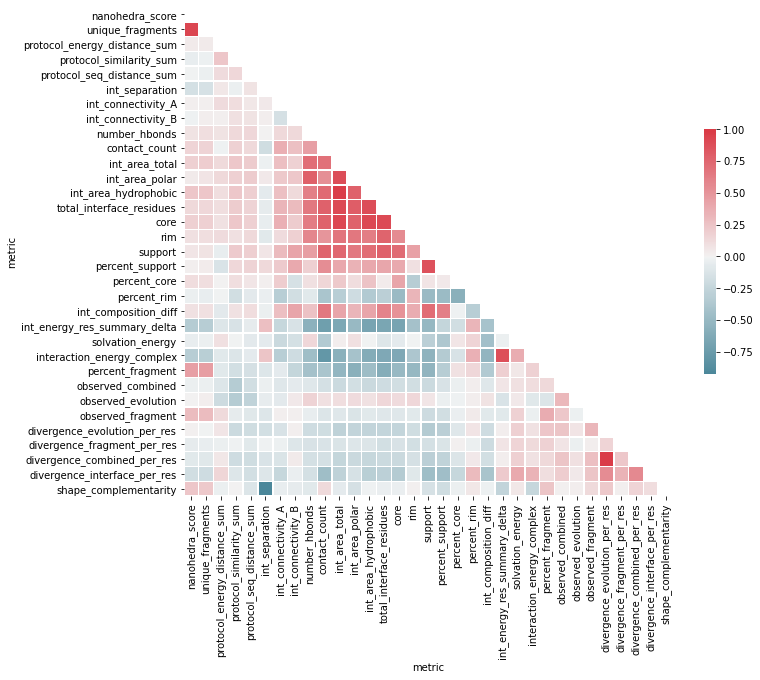

In [40]:
corr_df = subset_df[metrics_of_interest]
corr = corr_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Here you could plot pairs of correlated variables
add the pairs as a tuple in the metric pairs list

-0.029434861957629836

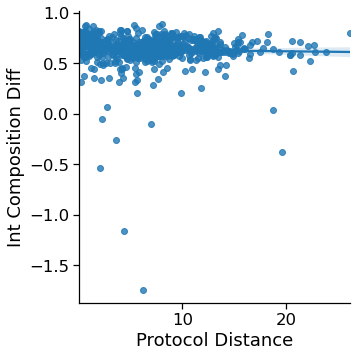

-0.185024865705374

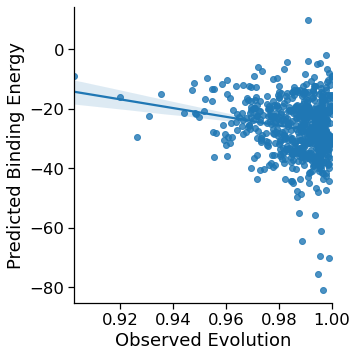

-0.05190526664245933

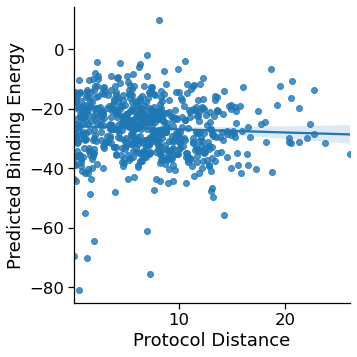

0.21795811793523265

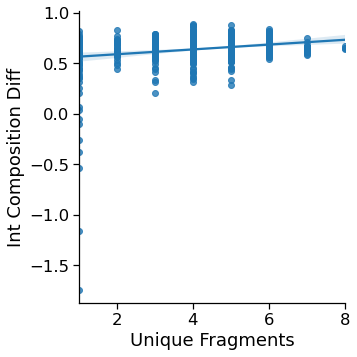

0.2398782586755383

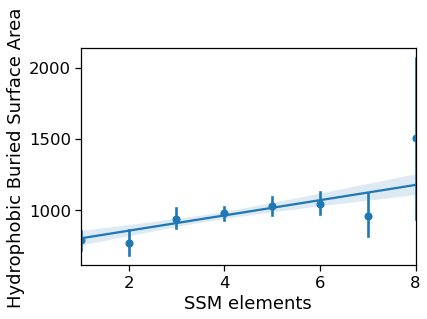

0.251007627103954

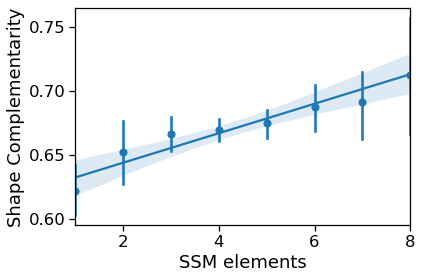

-0.30176420455599384

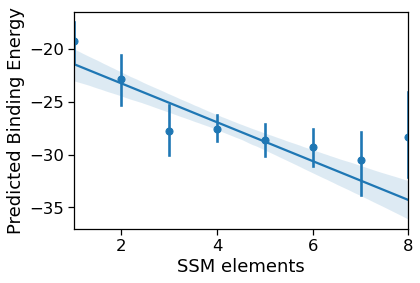

In [42]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [
#                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
#                 ('interaction_energy_complex', 'int_energy_res_summary_delta'),
#                 ('divergence_interface_per_res', 'contact_count'), 
#                 ('shape_complementarity', 'int_separation'),
#                 ('percent_support', 'int_composition_diff'),
#                 ('percent_rim', 'int_composition_diff'),
#                 ('percent_core', 'int_composition_diff'),
#                 ('int_composition_diff', 'int_energy_res_summary_delta'),
                ('protocol_energy_distance_sum', 'int_composition_diff'),
                ('observed_evolution', 'int_energy_res_summary_delta'),
                ('protocol_energy_distance_sum', 'int_energy_res_summary_delta'),
                ('unique_fragments', 'int_composition_diff')
#                 ('observed_evolution', 'protocol_energy_distance_sum'),
#                 ('observed_evolution', 'protocol_seq_distance_sum'),
#                 ('percent_fragment', 'int_area_hydrophobic'),
                ]
bar_plot_pairs = [
                  ('unique_fragments', 'int_area_hydrophobic'),
                  ('unique_fragments', 'shape_complementarity'),
                  ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
                 ]
# for x, y in combinations(metric_pairs):
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in metric_pairs:
        display(subset_df[x].corr(subset_df[y]))
        ax = sns.lmplot(x=x, y=y, data=subset_df)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        if x == 'protocol_energy_distance_sum':
            x = 'protocol_distance'
        ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
        plt.show()
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in bar_plot_pairs:
        display(subset_df[x].corr(subset_df[y]))
    #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#         ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        ax = sns.regplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        elif y == 'int_area_hydrophobic':
            y = 'hydrophobic_buried_surface_area'
        ax.set(xlabel='SSM elements', ylabel=' '.join(y.split('_')).title())  # format into a fancier axis title
        plt.show()
# sns.pairplot(subset_df, x_vars=['shape_complementarity', 'int_energy_res_summary_delta'], y_vars=['unique_fragments'],
#              height=5, aspect=.8, kind="reg")
# sns.pairplot(subset_df, y_vars=['shape_complementarity', 'int_energy_res_summary_delta'], x_vars=['unique_fragments'],
#             aspect=.8, kind="reg") # height=5
# sns.lmplot(x=y, y=x, data=subset_df, x_estimator=np.mean, col='vars', hue='vars')

0.5358091674094778

0.8198734978002182

-0.4348166451353058

-0.9396953085946905

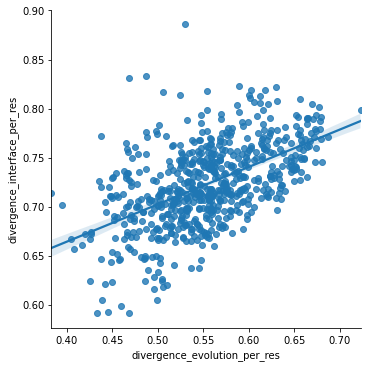

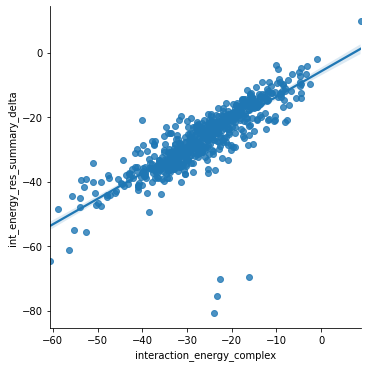

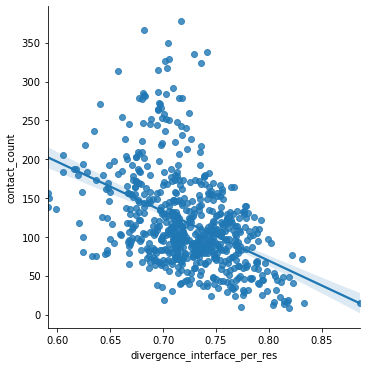

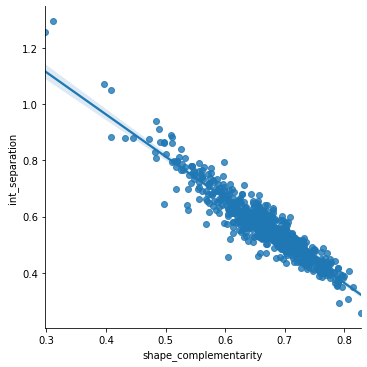

In [43]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [('divergence_evolution_per_res', 'divergence_interface_per_res'), 
                ('interaction_energy_complex', 'int_energy_res_summary_delta'),
                ('divergence_interface_per_res', 'contact_count'), 
                ('shape_complementarity', 'int_separation'), ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    sns.lmplot(x=x, y=y, data=subset_df)

In [44]:
metrics_of_interest = {'observed_evolution': '% Residues Obs. Evol.',
                       'int_area_total': 'Buried Surface Area (BSA)',
                       'shape_complementarity': 'Shape Complementarity',
                       'int_energy_res_summary_delta': 'Predicted Binding Energy', 
#                        'contact_count': 'Carbon-Carbon Contacts', 
                       'percent_int_area_hydrophobic': 'Hydrophobic BSA',
                       'number_hbonds': 'H-bonds',
                       'buns_total': 'Buried Unsat. H-bonds',
#                        'core', 'rim', 'support']  #'interaction_energy_complex', 'int_area_hydrophobic',
#                              'int_area_polar', 'int_area_total']
                      }

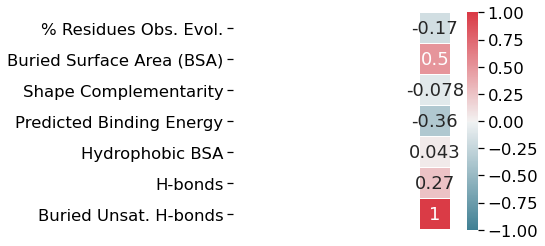

In [46]:
subset_df = protocol_df.droplevel(0, axis=1)
subset_df = subset_df['protocol_energy_distance_sum']
protocol_energy = {'protocol_energy_distance_sum': 'Protocol Distance'}
metrics_of_interest2 = metrics_of_interest.copy()
metrics_of_interest2.update(protocol_energy)
constraint_corr_df = pd.merge(no_constraint_protocol_df.droplevel(0, axis=1), subset_df, left_index=True, right_index=True)
subset_constraint_corr_df = constraint_corr_df[list(metrics_of_interest.keys())]  # + list(protocol_energy.keys())
subset_constraint_corr_df = subset_constraint_corr_df.rename(columns=metrics_of_interest)
corr = subset_constraint_corr_df.corr(method='spearman')
# mask = np.ones_like((len(corr), len(corr) - 1), dtype=np.bool)

# Generate a mask to display only correlations of interest
mask = np.ones_like(corr, dtype=np.bool)
# display(mask)
for i, row in enumerate(mask):
    mask[i][-1] = False
# display(mask)
# display(mask[: ,-1])
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Plot
with sns.plotting_context("notebook", font_scale=1.5):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, # cbar_kws={"shrink": .5},
                annot=True, xticklabels=False)

-0.04896870293552273

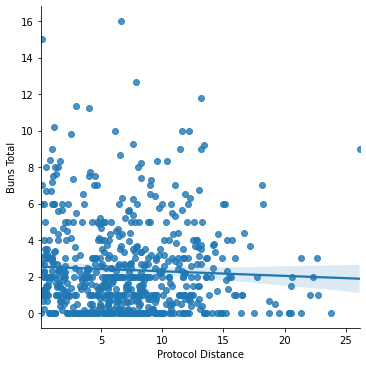

0.029807015989423515

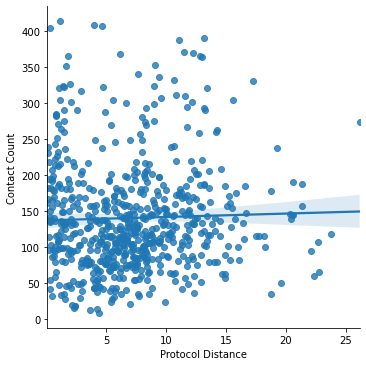

0.1093822884764262

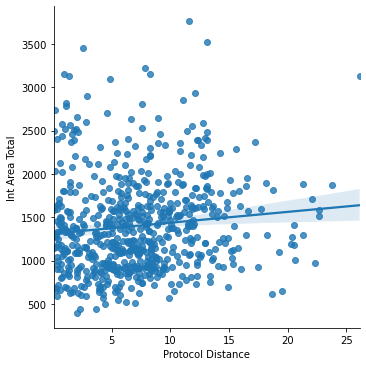

-0.11056487163124432

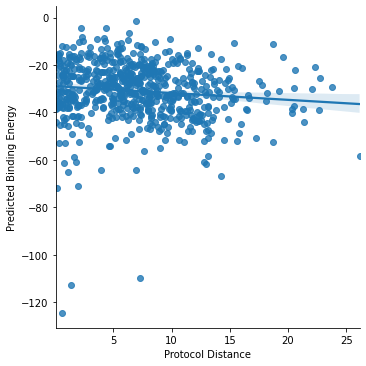

-0.10115573712066464

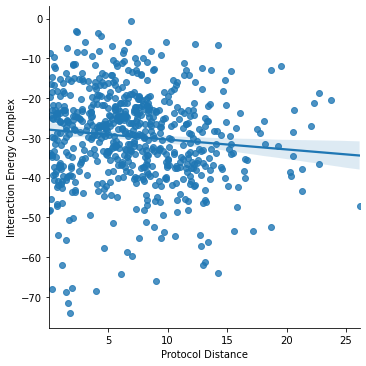

0.0767432887230824

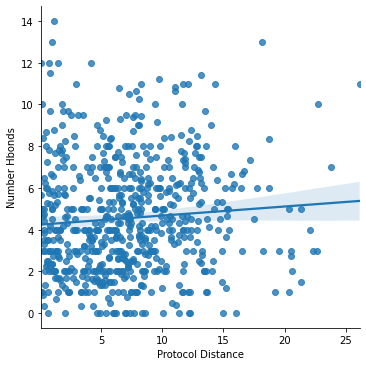

0.05537641329509701

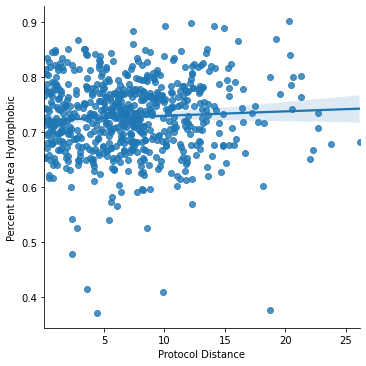

0.06912498379015046

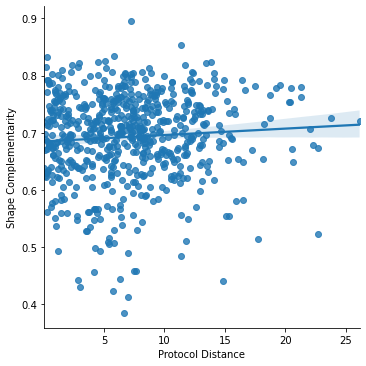

0.06575461634767506

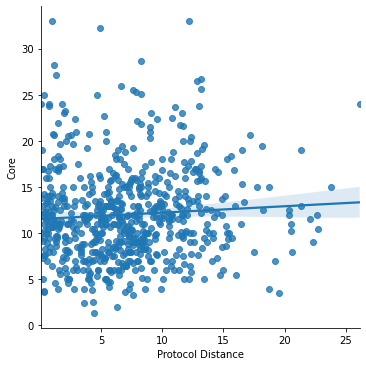

-0.009475537181021105

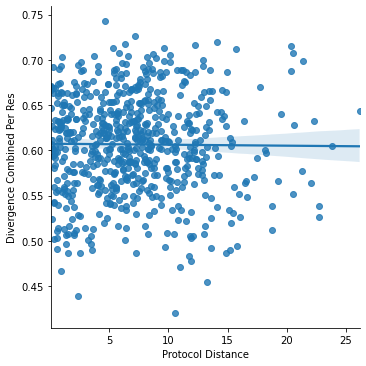

-0.023026973333753604

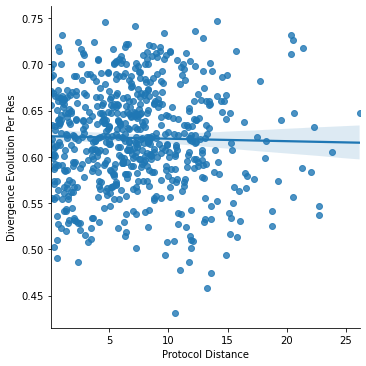

-0.03461434833483293

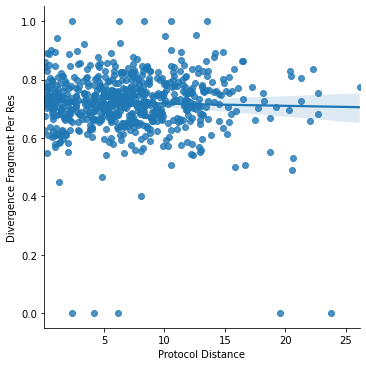

0.13714494644246372

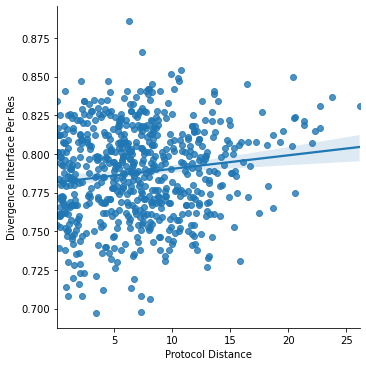

-0.06785635968687807

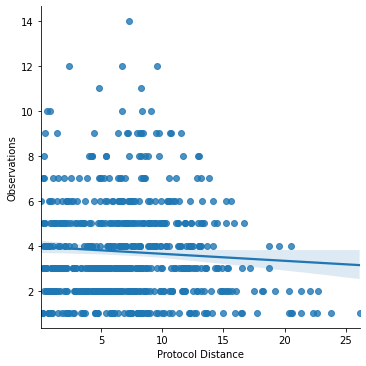

-0.06390743279626111

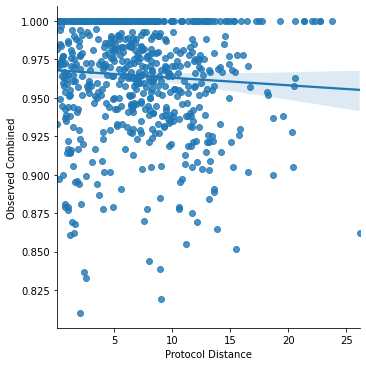

-0.1111422783025701

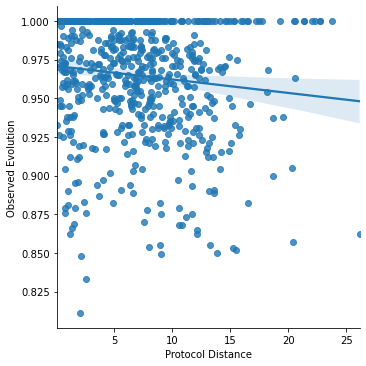

0.03497266934384523

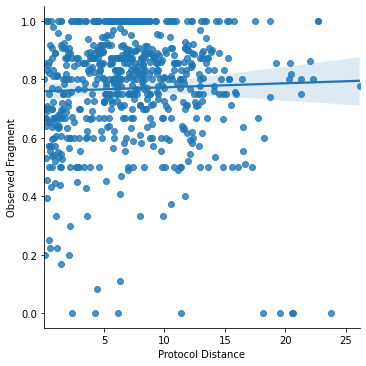

0.052375776552585296

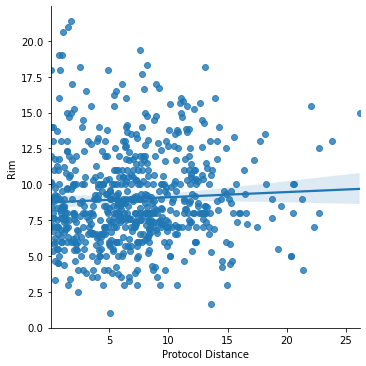

-0.01910454984823349

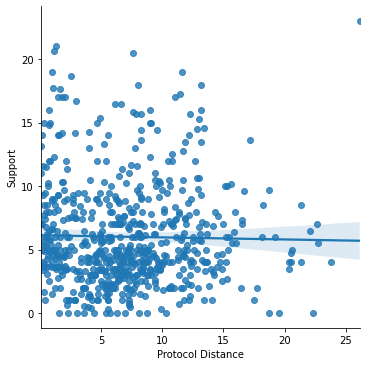

1.0

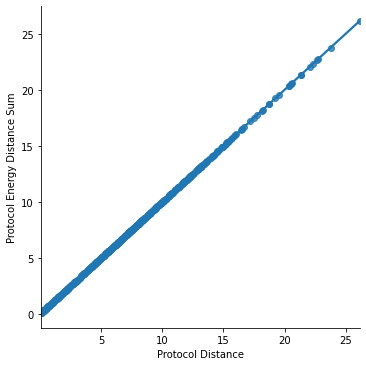

In [47]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
# subset_df = protocol_df.droplevel(0, axis=1)
# metric_pairs = [
# #                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
# #                 ('interaction_energy_complex', 'int_energy_res_summary_delta'),
# #                 ('divergence_interface_per_res', 'contact_count'), 
# #                 ('shape_complementarity', 'int_separation'),
# #                 ('percent_support', 'int_composition_diff'),
# #                 ('percent_rim', 'int_composition_diff'),
# #                 ('percent_core', 'int_composition_diff'),
# #                 ('int_composition_diff', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_composition_diff'),
#                 ('observed_evolution', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_energy_res_summary_delta'),
#                 ('unique_fragments', 'int_composition_diff')
# #                 ('observed_evolution', 'protocol_energy_distance_sum'),
# #                 ('observed_evolution', 'protocol_seq_distance_sum'),
# #                 ('percent_fragment', 'int_area_hydrophobic'),
#                 ]
subset_df = constraint_corr_df
from itertools import repeat
metric_pairs = zip(repeat('protocol_energy_distance_sum'), constraint_corr_df.columns.to_list())
# bar_plot_pairs = [
#                   ('unique_fragments', 'int_area_hydrophobic'),
#                   ('unique_fragments', 'shape_complementarity'),
#                   ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
#                  ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    ax = sns.lmplot(x=x, y=y, data=subset_df)
    if y == 'int_energy_res_summary_delta':
        y = 'predicted_binding_energy'
    if x == 'protocol_energy_distance_sum':
        x = 'protocol_distance'
    ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
    plt.show()
# for x, y in bar_plot_pairs:
#     display(subset_df[x].corr(subset_df[y]))
# #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#     ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
#     if y == 'int_energy_res_summary_delta':
#         y = 'predicted_binding_energy'
#     elif y == 'int_area_hydrophobic':
#         y = 'hydrophobic_buried_surface_area'
#     ax.set(xlabel='SSC elements', ylabel=' '.join(y.split('_')).title())
#     plt.show()

In [48]:
protocols_of_interest_freeVnot = {'no_constraint': 'Free', 'combo_profile': 'Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest_all = {'no_constraint': 'Free', 'combo_profile': 'Constraint', 'limit_to_profile': 'Latent Evolution', 'favor_profile': 'Weighted Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest = protocols_of_interest_freeVnot

## Reformat the data to pull specific columns and make a vertically stacked dataframe to produce Bar graphs which have a normalized z-value and are thus comparable across different scalar ranges

In [49]:
# from sklearn.preprocessing import StandardScaler

# normalized_df = design_protocols_df.subtract(design_protocols_df.min())

# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(design_protocols_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
# display(bar_df)
# display(bar_df.loc[:, ['Protocol']].isin(protocols_of_interest)['Protocol'])
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Protocol']].isin(protocols_of_interest.keys())['Protocol']]
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Metric']].isin(metrics_of_interest.keys())['Metric']]
# bar_df = bar_df[bar_df.loc[:, ['Protocol']] == protocols_of_interest]
display(bar_df)

Value  \
                                    metric                       protocol                     
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile     2.642857   
                                                                 no_constraint     6.400000   
                                    int_area_total               combo_profile  1645.445243   
                                                                 no_constraint  1795.745410   
                                    int_energy_res_summary_delta combo_profile   -36.732404   
...                                                                                     ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint     1.000000   
                                    percent_int_area_hydrophobic combo_profile     0.614864   
                                                                 no_constraint     0.541758   
                                    shape_complementarity        combo_profile     0.639006   
                                                                 no_constraint     0.649500   

                                                                                                      Metric  \
                                    metric                       protocol                                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile                    buns_total   
                                                                 no_constraint                    buns_total   
                                    int_area_total               combo_profile                int_area_total   
                                                                 no_constraint                int_area_total   
                                    int_energy_res_summary_delta combo_profile  int_energy_res_summary_delta   
...                                                                                                      ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint            observed_evolution   
                                    percent_int_area_hydrophobic combo_profile  percent_int_area_hydrophobic   
                                                                 no_constraint  percent_int_area_hydrophobic   
                                    shape_complementarity        combo_profile         shape_complementarity   
                                                                 no_constraint         shape_complementarity   

                                                                                     Protocol  
                                    metric                       protocol                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_area_total               combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_energy_res_summary_delta combo_profile  combo_profile  
...                                                                                       ...  
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  no_constraint  
                                    percent_int_area_hydrophobic combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    shape_complementarity        combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  

[9086 rows x 3 columns]

In [50]:
# First, normalize the data according to protocol groups
# display(bar_df.groupby('Metric').mean())
display(bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std()))
normalize_df = bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std())

# display(bar_df.groupby('Metric').min())
bar_s = bar_df.groupby('Metric').mean().squeeze()
# bar_s['int_energy_res_summary_delta'] = bar_s['int_energy_res_summary_delta'] * -1
# inverted_energy_df = bar_df
# inverted_energy_df['Value'] = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == 'int_energy_res_summary_delta', :], 'Value'] * -1
# display(inverted_energy_df)
mean_bar_s = bar_s
final_bar_df = bar_df
# display(mean_bar_s)
# bar_df[bar_df.loc[:, ['Metric']].isin(mean_bar_df)['Protocol']]
new_bar_l = []
for metric, metric_mean in zip(mean_bar_s.index, mean_bar_s):
#     print(metric_mean)
#     print(metric)
#     display(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], :])
#     print(bar_df[bar_df.loc[:, ['Metric']] == metric])
#     display(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
    if metric == 'int_energy_res_summary_delta':
        temp_df = pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean)
        new_bar_l.append(1 - (temp_df - 1))
    else:
        new_bar_l.append(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
new_bar_df = pd.concat(new_bar_l)
# display(new_bar_df)
#     new_bar_df = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean
    
#     bar_df = bar_df[bar_df.loc[:, ['Metric']] == metric] * metric_mean
# display(bar_df.loc[idx[:, :, :], ['Value']])
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# display(scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']]))
# final_bar_df['Value'] = scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']])

final_bar_df['Z-score'] = normalize_df.loc[idx[:, :, :], ['Value']]
# final_bar_df['Value'] = new_bar_df.loc[idx[:, :, :], ['Value']]
final_bar_df.rename(index=metrics_of_interest)

Value
                                    metric                       protocol               
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  0.158410
                                                                 no_constraint  1.804591
                                    int_area_total               combo_profile  0.505287
                                                                 no_constraint  0.789358
                                    int_energy_res_summary_delta combo_profile -0.729248
...                                                                                  ...
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  0.812255
                                    percent_int_area_hydrophobic combo_profile -1.458889
                                                                 no_constraint -2.536411
                                    shape_complementarity        combo_profile -0.504788
                                                                 no_constraint -0.370576

[9086 rows x 1 columns]

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

In [93]:
def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)

In [94]:
map_level(final_bar_df, metrics_of_interest, level=1)
map_level(final_bar_df, protocols_of_interest, level=2)

final_bar_df['Metric'] = final_bar_df.index.get_level_values(1)
final_bar_df['Protocol'] = final_bar_df.index.get_level_values(2)
                 
display(final_bar_df)

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

## Original view of all protocols
I started with int_energy_context_delta, shape_complementarity, buns_total, contact_count', 'interaction_energy_complex', int_area_hydrophobic, int_area_polar, int_area_total, number_hbonds

After analysis, it seems that some are not useful or the axis need to be moved to visualize. I am also trying different data shapes

I have finally reworked this so that the values are comparable. Scaling by mean and SD of each allows comparisons to be made. I specifically looked at combo_profile (Constrained, Constraint) versus no_constraint (Unconstrained, Free) protocols

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

<AxesSubplot:xlabel='Value', ylabel='Density'>

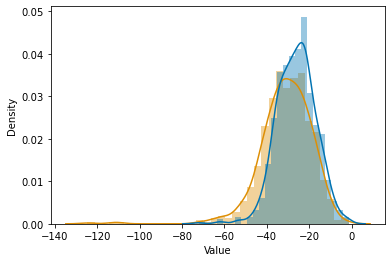

In [52]:
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Free'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[1])
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[0])
# sns.plot.show()

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


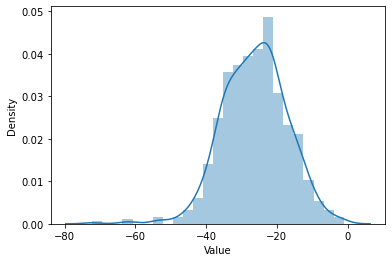

In [53]:
ax = sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


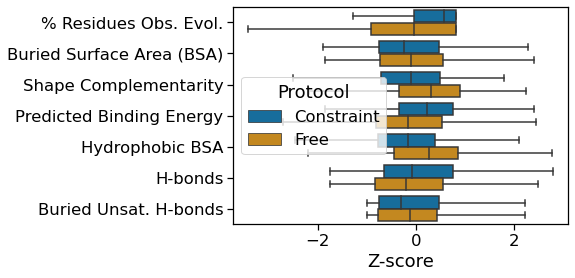

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


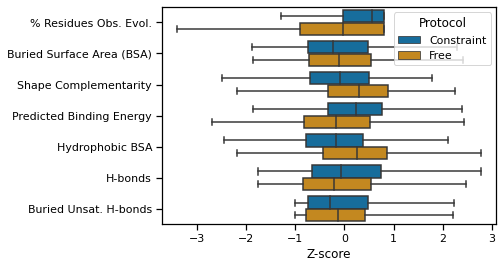

In [54]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

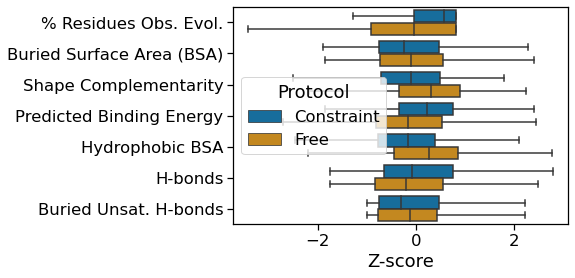

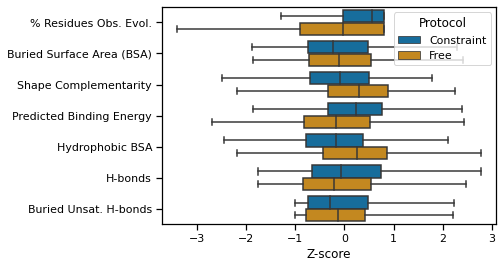

In [55]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

In [ ]:
protocol_specific_columns = ['int_energy_res_summary_delta', 'shape_complementarity',
                             'buns_total', 'contact_count', 'number_hbonds']
for metric in protocol_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['Metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="Protocol", y='Value', kind='box', data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

In [ ]:
bsa_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'int_area_hydrophobic'], bar_df[bar_df['Metric'] == 'int_area_polar'], bar_df[bar_df['Metric'] == 'int_area_total']])
# bar_df[bar_df['metric'] == 'int_area_hydrophobic']
# bar_df[bar_df['metric'] == 'int_area_polar']
# bar_df[bar_df['metric'] == 'int_area_total']
# display(bsa_bar_df)

In [ ]:
# with SD
# plt.figure(figsize=(100, 6))
# sns.barplot(x="metric", hue="protocol", y='Value', ci='sd', data=bsa_bar_df)
sns.catplot(x='Metric', y='Value', hue='Protocol', kind='violin', aspect=2, data=bsa_bar_df)  # hue="protocol", ci='sd'
plt.show()

# with 95% confidence interval
plt.figure(figsize=(20, 6))
sns.barplot(x='Metric', hue='Protocol', y='Value', data=bsa_bar_df)
plt.show()

In [ ]:
# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(seq_stats_protocol_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
display(bar_df)

In [ ]:
divergence_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'divergence_interface_per_res'], bar_df[bar_df['Metric'] == 'divergence_evolution_per_res']])
box = sns.catplot(x="Metric", y='Value', hue="Protocol", kind='box', aspect=2, data=divergence_bar_df)  #  ci='sd'
# ax = sns.boxplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'
# ax = sns.swarmplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'

In [ ]:
seq_specific_columns = ['divergence_interface_per_res', 'divergence_evolution_per_res']
# display(bar_df)
combo_favor_combined_df = pd.concat([bar_df[bar_df['protocol'] == 'combo_profile'], bar_df[bar_df['protocol'] == 'favor_profile']])
combo_favor_combined_df['protocol'] = 'combination'
bar_df = pd.concat([bar_df, combo_favor_combined_df])
for metric in seq_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="protocol", y='Value', kind='box', aspect=2, data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

## Need to add a couple of metrics to the Dataframe. All subsets are missing these...

In [ ]:
only_metrics_protocol_df = xtal_pose_df.droplevel(0, axis=1)
# only_metrics_protocol_df = columns_to_new_column(only_metrics_protocol_df, division_pairs, mode='truediv')
# display(only_metrics_protocol_df)
# only_metrics_protocol_df['percent_int_area_polar']

## Filtering by additional design filters which lead to good poses

I am going to remove designs not satisfying a couple of criteria that have been useful in past design work. This includes:

buried unsatisfied hydrogen bonds (Stranges and Khulman 2013): 2/1000A

percent polar interface area (): >30%

NOT YET number of h bonds: <10 <8?

In [ ]:
design_requirements = {'percent_int_area_polar': 0.4, 'buns_per_ang': 0.002}  #, 'number_hbonds': 10}
design_requirements.update(crystal_means)

In [8]:
filter_key_df = pd.DataFrame(master_metrics, index_col=0)
display(filter_key_df)

In [ ]:
crystal_filters = {column: {'direction': filter_key_df.loc['direction', column], 'value': design_requirements[column]} 
                   for column in design_requirements}

print('Starting designs = %d' % len(only_metrics_protocol_df))
print('Using filter parameters: %s' % str(crystal_filters))
crystal_filters_with_idx = df_filter_index_by_value(only_metrics_protocol_df, **crystal_filters)
# Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
# on whether the column should be sorted max/min
# Args:
#     df (pandas.DataFrame): DataFrame to filter indices on
# Keyword Args:
#     kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
for _filter in crystal_filters_with_idx:
    print('%s designs = %d' % (_filter, len(crystal_filters_with_idx[_filter]['idx'])))

In [ ]:
# print(crystal_filters_with_idx)
design_indices = {_filter: crystal_filters_with_idx[_filter]['idx'] for _filter in crystal_filters_with_idx}
# display(design_indices[0])
symmetry_and_design_filtered_idx = index_intersection(design_indices)
print('Final number of designs passing all metrics is %d' % len(symmetry_and_design_filtered_idx))
symmetry_and_design_filtered_df = only_metrics_protocol_df.loc[symmetry_and_design_filtered_idx, :]